# ECE 57000 Assignment 5 Exercise

Your Name: Souradip Pal

# Exercise 1: Define classifier that extracts latent representations and visualize representations (**30 points**)

The latent (i.e., hidden) representations generated by a deep neural network are very important concept in deep learning since the latent space is where the most significant features of the dataset are learned and extracted.
In this homework, we will explore the latent representations of a classifier using clustering and nearest neighbor methods.

We provide the code for a simple residual CNN with batchnorm and data loaders.

*  Here, we define a neural network block architecture that does batch normalization after each convolution layer and has a skip connection. You can read more about batch normalization and skip connections in these papers https://arxiv.org/pdf/1502.03167.pdf and https://arxiv.org/pdf/1512.03385.pdf, respectively.
*  In this neural network, the block networks are designed so that the input dimension and the output dimension stay the same. This may not be an optimal design, but it will help us visualize the latent representation later.

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class SimpleResidualBlock(nn.Module):
    def __init__(self, ch_in, mult=4):
        super().__init__()
        self.conv1 = nn.Conv2d(ch_in, mult * ch_in, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(mult * ch_in)
        
        self.conv2 = nn.Conv2d(mult * ch_in, mult * ch_in, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(mult * ch_in)

        self.conv3 = nn.Conv2d(mult * ch_in, ch_in, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(ch_in)
    
    def forward(self, x):
        x_ = x.clone()
        x_ = torch.relu(self.bn1(self.conv1(x_)))
        x_ = torch.relu(self.bn2(self.conv2(x_)))
        x_ = torch.relu(self.bn3(self.conv3(x_)))
        x = x + x_
        return x

class SimpleResNet(nn.Module):
    def __init__(self, ch_in, n_blocks=3):
        super().__init__()
        self.residual_layers = nn.ModuleList([SimpleResidualBlock(ch_in) for i in range(n_blocks)])
        self.maxpool = nn.MaxPool2d((2, 2))
        self.fc = nn.Linear(9, 10)

    def forward(self, x):
        for residual in self.residual_layers:
          x = residual(x)
          x = self.maxpool(x)
        x = x.view(x.shape[0], -1)  # Unravel tensor dimensions
        out = self.fc(x)
        return out

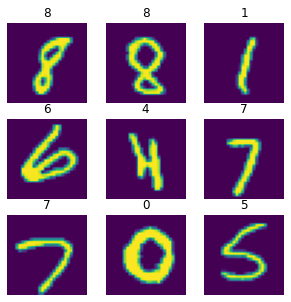

In [3]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Create MNIST datasets
classes = np.arange(10)
transform = torchvision.transforms.Compose(
  [torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create dataloaders
batch_size_train, batch_size_test = 64, 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

# Show sample images
batch_idx, (images, targets) = next(enumerate(train_loader))
fig, ax = plt.subplots(3,3,figsize = (5,5))
for i in range(3):
  for j in range(3):
    image = images[i*3+j].permute(1,2,0)
    image = image/2 + 0.5
    ax[i,j].imshow(image.squeeze(2))
    ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
    ax[i,j].axis('off')
fig.show()

### Task 1: Extend the original model that computes the same output but also produces intermediate representations (including the original input)

Specifically, the function below should return the original output and a list of intermediate representations `z_list`. `z_list` should be a Python list with 4 entries corresponding to the original batch and the batch after each maxpool layer.

In [4]:
class SimpleResNetWithRepresentations(SimpleResNet):
  def compute_and_extract_representations(self, x):
    # ---------- Your code ----------
    z_list = [x]
    for residual in self.residual_layers:
          x = residual(x)
          x = self.maxpool(x)
          z_list.append(x)
    x = x.view(x.shape[0], -1)
    out = self.fc(x)
    # ---------- End your code ----------
    return out, z_list
  
model = SimpleResNetWithRepresentations(ch_in=1)
model.to(device)
images, labels = next(iter(test_loader)) # get a batch
images = images.to(device)
# Check that outputs match
out, z_list = model.compute_and_extract_representations(images)
assert torch.all(model(images) == out), 'Outputs should be the same'
# Check shapes of representations
assert len(z_list) == 4, 'Should have length of 4'
assert torch.all(z_list[0] == images), 'First entry should be original data'
for zi, z in enumerate(z_list):
  print(f'Representation z{zi} batch shape = {z.shape}')

Representation z0 batch shape = torch.Size([128, 1, 28, 28])
Representation z1 batch shape = torch.Size([128, 1, 14, 14])
Representation z2 batch shape = torch.Size([128, 1, 7, 7])
Representation z3 batch shape = torch.Size([128, 1, 3, 3])


### Task 2: Train the model

Using the train and test functions given above, train `model` for 4 epochs using the Adam optimizer with a learning rate of 0.01.

In [5]:
def train(epoch, model, optimizer):
    model.train() # we need to set the mode for our model
    for batch_idx, (images, targets) in enumerate(train_loader):
      images = images.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      output = model(images)
      loss = F.cross_entropy(output, targets) # Here is a typical loss function (negative log likelihood)
      loss.backward()
      optimizer.step()
      if batch_idx % 100 == 0: # We visulize our output every 10 batches
        print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

def test(epoch, model):
  model.eval() # we need to set the mode for our model
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for images, targets in test_loader:
      images = images.to(device)
      targets = targets.to(device)
      output = model(images)
      test_loss += F.cross_entropy(output, targets, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
  test_loss /= len(test_loader.dataset)
  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

# ----------- <Your code> ---------------
import torch.optim as optim

adam = optim.Adam(model.parameters(), lr=0.01)

max_epoch = 4
for epoch in range(1, max_epoch+1):
  train(epoch, model, adam)
  test(epoch, model)
# ----------- <End Your code> ---------------

Epoch 1: [0/60000] Loss: 7.160950183868408
Epoch 1: [6400/60000] Loss: 1.3451344966888428
Epoch 1: [12800/60000] Loss: 0.740911602973938
Epoch 1: [19200/60000] Loss: 0.5296585559844971
Epoch 1: [25600/60000] Loss: 0.6472468972206116
Epoch 1: [32000/60000] Loss: 0.550967812538147
Epoch 1: [38400/60000] Loss: 0.24298736453056335
Epoch 1: [44800/60000] Loss: 0.49357280135154724
Epoch 1: [51200/60000] Loss: 0.209747776389122
Epoch 1: [57600/60000] Loss: 0.2962729334831238
Test result on epoch 1: Avg loss is 0.41046653947830203, Accuracy: 86.38999938964844%
Epoch 2: [0/60000] Loss: 0.1749081015586853
Epoch 2: [6400/60000] Loss: 0.2068769484758377
Epoch 2: [12800/60000] Loss: 0.39931347966194153
Epoch 2: [19200/60000] Loss: 0.2934819757938385
Epoch 2: [25600/60000] Loss: 0.22891396284103394
Epoch 2: [32000/60000] Loss: 0.5577534437179565
Epoch 2: [38400/60000] Loss: 0.3995327949523926
Epoch 2: [44800/60000] Loss: 0.33867812156677246
Epoch 2: [51200/60000] Loss: 0.27053654193878174
Epoch 2: [

### Task 3: Visualize the intermediate latent representations

*   Plot the representations of 20 images from the test dataset in a supblots grid of shape (20, 4) (code already given for setting up these subplots) where the rows correspond to samples in the dataset and columns correspond to the representations produced by `compute_and_extract_representations`

Notes:
*   We give code below for normalizing the image and plotting on an axis with a title.
*   Make sure to set `model.eval()` when computing because of the batchnorm layers
*   No title or ylabel is needed in this case.

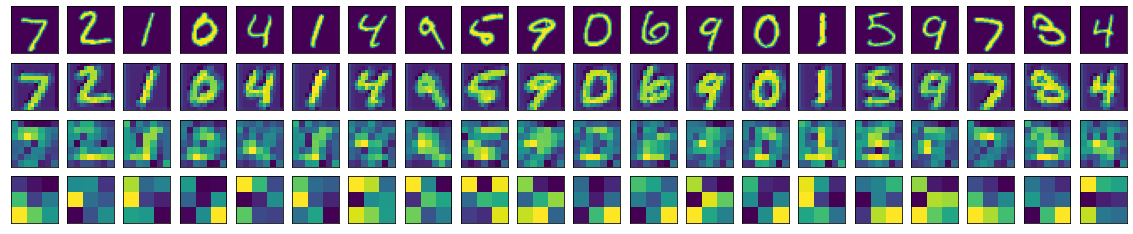

In [6]:
def plot_representation(z, ax):
  # Normalize image for visualization
  assert z.ndim == 3, 'Should be 3 dimensional tensor with C x H x W'
  z = (z - z.min())/(z.max() - z.min())
  if torch.is_tensor(z):  # Convert torch tensor to numpy if needed
    z = z.detach().cpu().numpy()
  ax.imshow(z.transpose((1,2,0)).squeeze(2))
  # Remove ticks and ticklabels to make plot clean
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels([])
  ax.set_yticklabels([])

n_show = 20
fig, axes_mat = plt.subplots(4, n_show, figsize=[n_show, 4])
# ----------- Your code ---------------
model.eval()
batch_idx, (images, targets) = next(enumerate(test_loader))
images = images.to(device)
out, z_list = model.compute_and_extract_representations(images)

for j, z in enumerate(z_list):
    for i in range(n_show):
        plot_representation(z[i], axes_mat[j, i])
# ----------- End your code ---------------

Notice how the representations become more and more abstract as the depth increases.

# Exercise 2: Clustering with different representations (40 points)

### Task 1: Create simple numpy arrays of the representations
To perform further manipulations in numpy and scikit-learn, we will need to create simple numpy arrays for each representation. We provide the code for merging multiple batches. You will need to provide the code for extracting from the given data loader.

* Loop through the data loader and extract representations for each batch
* Append the labels and z_list to corresponding lists
* Break out of loop when the number extracted is n_extract or greater

In [7]:
def extract_numpy_representations(model, data_loader, n_extract):
  extracted_z_lists = []
  labels_list = []
  # ------------- Your code ---------------
  for batch_idx, (images, targets) in enumerate(data_loader):
      images = images.to(device)
      model = model.to(device)
      out, z_list = model.compute_and_extract_representations(images)
      labels_list.append(out.data.max(1, keepdim=True)[1])
      extracted_z_lists.append(z_list)
      if len(labels_list)*labels_list[0].shape[0] >= n_extract:
          break
  # ------------- End your code ---------------
  # Check extracted_z_lists (type should be tensor)
  print(f'Types of first batch\n    {[type(z) for z in extracted_z_lists[0]]}')
  print(f'Shapes of first batch\n    {[z.shape for z in extracted_z_lists[0]]}')
  
  # Merge extracted z_lists and labels and make numpy arrays
  z_list_merge_np = [
    np.vstack([
      z_list[i].detach().cpu().numpy()
      for z_list in extracted_z_lists
    ])[:n_extract]  # Extract up to n_extract
    for i in range(len(extracted_z_lists[0]))
  ]
  print(f'Types of merged lists\n    {[type(z) for z in z_list_merge_np]}')
  print(f'Shapes of merged lists\n    {[z.shape for z in z_list_merge_np]}')
  labels_merged_np = np.concatenate([
    labels.detach().cpu().numpy()
    for labels in labels_list
  ])[:n_extract]  # Extract up to n_extract
  print(f'Shape of merged labels\n    {labels_merged_np.shape}')
  return z_list_merge_np, labels_merged_np

# Extract train and test samples
z_list_train, labels_train = extract_numpy_representations(model, train_loader, n_extract=200)
z_list_test, labels_test = extract_numpy_representations(model, test_loader, n_extract=200)
# Extract regular train and test
x_test = z_list_test[0]
x_train = z_list_train[0]

Types of first batch
    [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]
Shapes of first batch
    [torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 14, 14]), torch.Size([64, 1, 7, 7]), torch.Size([64, 1, 3, 3])]
Types of merged lists
    [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Shapes of merged lists
    [(200, 1, 28, 28), (200, 1, 14, 14), (200, 1, 7, 7), (200, 1, 3, 3)]
Shape of merged labels
    (200, 1)
Types of first batch
    [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]
Shapes of first batch
    [torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 14, 14]), torch.Size([128, 1, 7, 7]), torch.Size([128, 1, 3, 3])]
Types of merged lists
    [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Shapes of merged lists
    [(200, 1, 28, 28), (200, 1, 14, 14), (200, 1, 7, 7), (200, 1,

### Task 2: Perform K-means clustering on different representations

In this task, we will perform kmeans clustering on each of the latent representations of the test set and then evaluate the clustering based on the true class labels.
A good discussion of clustering metrics can be found in [scikit-learn's documentation on clustering metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

* Using scikit-learn's [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) estimator, perform kmeans with $k=10$ and `random_state=0` on the latent representations and extract the cluster labels.
* Use [`sklearn.metrics.adjusted_rand_score`]() to compute a score to evaluate the clustering based on the true class labels.

Notes:
* You will need to reshape the tensors into matrices immediately before passing into sklearn functions (you should keep the original data as is so that the images can be plotted, but just reshape immediately before passing into scikit-learn functions). Specifically, the arrays will have shape (B, C, H, W) and you should reshape to (B, C*H*W) before passing to scikit-learn functions.
* We provide code for plotting and evaluating your clustering.

In [8]:
def plot_cluster(cluster_labels, z_test, title):
  # Plot the top images in each cluster both in original space and latent representation
  n_samples_show, n_clusters = 5, 10
  nr, nc = n_samples_show, 2*n_clusters
  fig, axes_mat = plt.subplots(nr, nc, figsize=np.array([nc, nr])/2)
  axes_mat_list = np.split(axes_mat, n_clusters, axis=1)
  for ci, axes_mat in enumerate(axes_mat_list): # Loop over clusters
    sel = cluster_labels==ci
    z_cluster = z_test[sel][:n_samples_show]
    x_cluster = x_test[sel][:n_samples_show]
    for test_i, (z, x, axes) in enumerate(zip(z_cluster, x_cluster, axes_mat)):
      plot_representation(x, axes[0])
      plot_representation(z, axes[1])
      if ci == 0:
        axes[0].set_ylabel(test_i)
      if test_i == len(axes_mat)-1:
        axes[0].set_xlabel(f'C{ci}x')
        axes[1].set_xlabel(f'C{ci}z')
  fig.suptitle(title)
  plt.show()

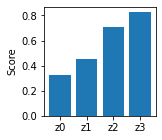

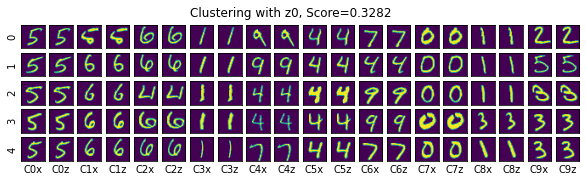

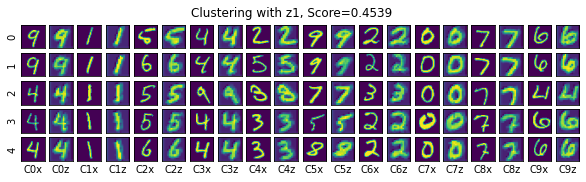

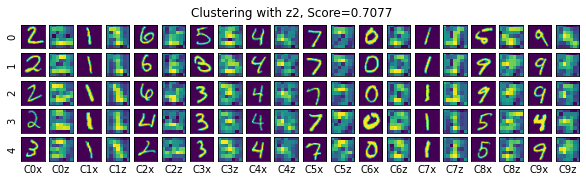

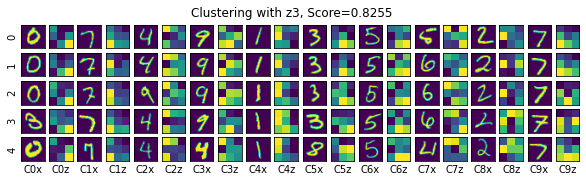

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def cluster_and_score(z, true_labels):
  # ----------- Your code ---------------
  X = z.reshape([z.shape[0],-1])
  kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
  cluster_labels = kmeans.labels_
  score = adjusted_rand_score(true_labels.reshape(-1), cluster_labels)
  # ----------- End your code ---------------
  return cluster_labels, score

fig = plt.figure(figsize=(2,2))
plt.bar([f'z{zi}' for zi in range(len(z_list_test))], 
        [cluster_and_score(z_test, labels_test)[1] for z_test in z_list_test]) 
plt.ylabel('Score')
for zi, z_test in enumerate(z_list_test):
  cluster_labels, score = cluster_and_score(z_test, labels_test)
  plot_cluster(cluster_labels, z_test, f'Clustering with z{zi}, Score={score:.4f}')


Notice how the 3x3 pattern for the last representation looks similar across the samples.

# Exercise 3: Nearest neigbhors methods using representations (30 points)

### Task 1: Compute and plot nearest neigbhors in different representations

We will now compute the nearest neighbor of test points compared to train points in different representations.

* Loop through the representations for the train and test numpy arrays (i.e., `z_list_train` and `z_list_test`).
* For each representaiton, compute the *training* indices corresponding to the nearest neighbor of 15 *testing* indices.
* Plot the neighbors by passing the test indices and corresponding nearest neighbor training indices along with the corresponding train and test representations and a title that describes which representation into `plot_neighbor`.

Notes:
* See note above about reshaping tensors immediately before passing to scikit-learn functions which expect a matrix.


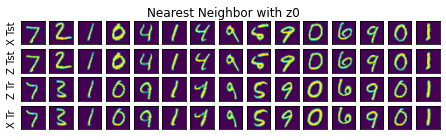

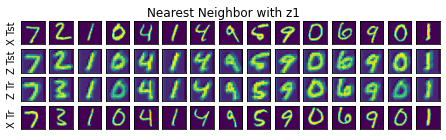

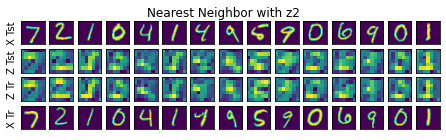

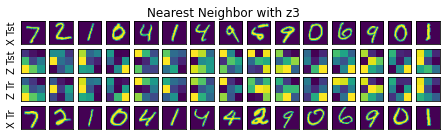

In [10]:
def plot_neigbhor(test_ind, nearest_train_ind, z_test, z_train, title):
  '''
  Plots the original test image, the test image representation,
    the nearest train image representation, the nearest original train image.
  '''
  assert len(test_ind) == len(nearest_train_ind), 'Test and train indices should be the same length'
  n_test = len(test_ind)
  fig, axes_mat = plt.subplots(4, n_test, figsize=np.array([n_test, 4])/2)
  for test_i, nearest_train_i, axes in zip(test_ind, nearest_train_ind, axes_mat.T):
    plot_representation(x_test[test_i], axes[0])
    plot_representation(z_test[test_i], axes[1])
    plot_representation(z_train[nearest_train_i], axes[2])
    plot_representation(x_train[nearest_train_i], axes[3])
    if test_i == 0:
      for lab, ax in zip(['X Tst', 'Z Tst', 'Z Tr', 'X Tr'], axes):
        ax.set_ylabel(lab)
  fig.suptitle(title)

# --------- Your code ---------
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

for i in range(4):
    z_ts = z_list_test[i]
    z_tr = z_list_train[i]
    
    test_ind = range(15)
    X_train = z_tr.reshape([z_tr.shape[0], -1])
    X_test = z_ts[test_ind].reshape([15, -1])

    nbrs = NearestNeighbors(n_neighbors=1)
    nbrs.fit(X_train)

    idx = nbrs.kneighbors(X_test, n_neighbors=1, return_distance=False)
    
    nearest_train_ind = idx.reshape(-1)
    plot_neigbhor(test_ind, nearest_train_ind, z_ts, z_tr, f'Nearest Neighbor with z{i}')
# --------- End your code ---------

Notice that some representations provide better nearest neighbors in terms of semantics (i.e., the same digit).

### Task 2: Create kneighbors graph, laplacian matrix, and determine number of connected components

In this task you will create a function that creates a k-neighbors graph, it's corresponding laplacian matrix, and the number of connected components. Specifically, we want the *undirected* k-neighbors graph (see note below). You will want to use the [`sklearn.neighbors.kneighbors_graph`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html) function.

* Compute the *undirected* adjacency matrix `A` where you include an edge if *either* $i$ is near to $j$ or vice versa (see notes below).
* Compute the laplacian matrix `L`.
* Compute the number of connected components.

Notes:
* `sklearn.neighbors.kneighbors_graph` returns a sparse CSR matrix. For our purposes, you should convert this to a dense matrix via `toarray()`. 
* The returned adjacency matrix is a *directed* k-neighbors graph (i.e., non-symmetric). To make it symmetric (i.e., an undirected), you should add the adjacency matrix to its transpose and make any non-zero a 1 (because entries could be 2 now).
* For eigendecomposition, you should use [`np.linalg.eigh`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html), which assumes the input is symmetric and only returns real-valued eigenvalues and eigenvectors. Also, because of numerical rounding, some eigenvalues may be slightly larger than 0. Thus, you can treat any eigenvalue below $10^{-10}$ to be 0.

In [11]:
from sklearn.neighbors import kneighbors_graph

def create_graph(z, n_neighbors):
  # -------- Your code ----------
  G = kneighbors_graph(z.reshape(z.shape[0], -1), n_neighbors).toarray()
  A = (G + G.T)
  A[A > 0] = 1
  D = np.diag(np.sum(A,axis=1))
  L = D - A
  w, v = np.linalg.eigh(L)

  n_connected_components = np.sum(w<1e-10)
  # -------- End your code ----------
  return A, L, n_connected_components

for n_neighbors in [2, 4, 8]:
  print(f'n_neighbors = {n_neighbors}')
  for zi, z_test in enumerate(z_list_test):
    A, L, ncc = create_graph(z_test, n_neighbors)
    assert np.all(A == A.T), '`A` should be symmetric'
    assert np.all(L == L.T), '`L` should be symmetric'
    print(f'  z{zi}: # of nonzeros in adjacency matrix = {np.sum(A != 0)}, # of connected components = {ncc}')

n_neighbors = 2
  z0: # of nonzeros in adjacency matrix = 596, # of connected components = 2
  z1: # of nonzeros in adjacency matrix = 594, # of connected components = 2
  z2: # of nonzeros in adjacency matrix = 600, # of connected components = 2
  z3: # of nonzeros in adjacency matrix = 566, # of connected components = 1
n_neighbors = 4
  z0: # of nonzeros in adjacency matrix = 1180, # of connected components = 1
  z1: # of nonzeros in adjacency matrix = 1104, # of connected components = 2
  z2: # of nonzeros in adjacency matrix = 1126, # of connected components = 1
  z3: # of nonzeros in adjacency matrix = 1082, # of connected components = 1
n_neighbors = 8
  z0: # of nonzeros in adjacency matrix = 2330, # of connected components = 1
  z1: # of nonzeros in adjacency matrix = 2228, # of connected components = 1
  z2: # of nonzeros in adjacency matrix = 2132, # of connected components = 1
  z3: # of nonzeros in adjacency matrix = 2068, # of connected components = 1


Notice that using more neighbors connects the graph more densely creating less connected components.

### Task 3: Perform spectral clustering on k-neighbors graph with $k=8$

In this task, you will perform spectral graph clustering where the number of neighbors is $k=8$ and the number of spectral components (i.e., eigenvectors corresponding to the smallest eigenvalues after the 0 eigenvalue) is $M=4$.

Notes:
* The eigendecomposition does not necessarily return eigenvalues in sorted order. You will need to select the eigenvectors corresponding to the $k$ smallest eigenvalues that are greater than 0 (or greater than $10^{-14}$ because of numerical precision).
* There is a small chance that some clusters have less than 5 points in them, which may cause the plots to have missing areas.
* See note in prior task about using `np.linalg.eigh`.

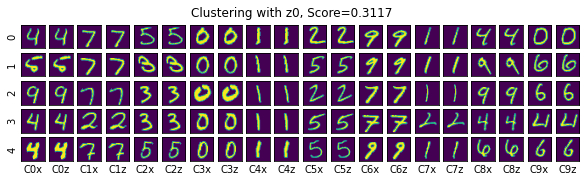

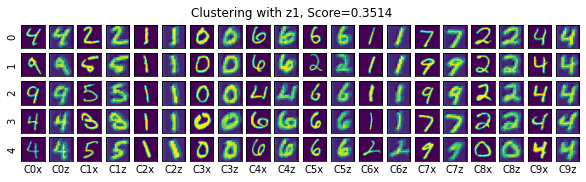

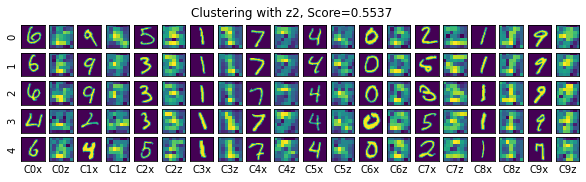

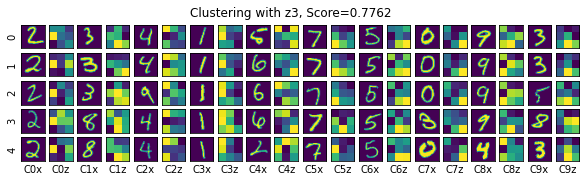

In [12]:
def spectral_cluster_and_score(z, other_labels):
  # -------- your code -------
  A, L, ncc = create_graph(z, 8)
  w, v = np.linalg.eigh(L)

  vecs = v[:,np.argsort(w)]
  vals = w[np.argsort(w)]
  
  vecs = vecs[:,vals > 1e-10]
  vals = vals[vals > 1e-10]
  
  X = vecs[:,:4]
  kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
  cluster_labels = kmeans.labels_
  score = adjusted_rand_score(other_labels.reshape(-1), cluster_labels)
  # -------- end your code -------
  return cluster_labels, score

for zi, z_test in enumerate(z_list_test):
  cluster_labels, score = spectral_cluster_and_score(z_test, labels_test)
  plot_cluster(cluster_labels, z_test, f'Clustering with z{zi}, Score={score:.4f}')